<a id='home'></a>
### purpose

see which datasets differed the most between AF and genotype data

### outline

1. [get performance data of GO$_{AF, pop}$ and GO$_{geno, pop}$](#data)
1. [compare AF,pop to geno,pop performance](#comp)

    a scatter plot of af,pop vs geno,pop
    
1. [explore data where geno,pop performance is better than af,pop](#exp)

    prints out percentages of better performance across simulation parameters
    
1. [compare differences in performance between AF,pop and geno,pop](#comp2)

    a histogram of af,pop minus geno,pop
    
1. [look at individual seed with most improvement](#look)

    this is largely now in 05_supplemental/07_conceptual_fig.ipynb

In [1]:
from pythonimports import *
from myfigs import scatter2d, draw_xy, histo_box, save_pdf, create_cmap

import runtime_API as rt
import MVP_summary_functions as mvp
import MVP_01_train_gradient_forests as mvp01
import MVP_03_validate_gradient_forests as mvp03
import MVP_06_validate_RONA as mvp06

import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl

fig_dir = makedir(f'{rt.resdir}/figures/05_supplemental/03_all_compare_workflows')

t0 = dt.now()  # notebook timer

rt.latest_commit()
session_info.show()

#########################################################
Today:	April 12, 2024 - 15:12:00 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 8b790072e7a46d7f58a30c40cf4660986a612764  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 2 13:55:49 2024 -0500

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='data'></a>
# get performance data of GO$_{AF, pop}$ and GO$_{geno, pop}$

[top](#home)

In [2]:
# get AF,pop data
pooled_results = rt.load_results('pooled', ignore_20k=True)

pooled_results.index = pooled_results.seed_garden + "_" + pooled_results.num_loci.astype(str)

pooled_results.head()

removing records for models using 20k loci
pooled shape = (162000, 17)
Function `load_results` completed after : 0-00:00:17


,garden,score,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,rep,num_loci,seed,demography,source,offset_level,seed_garden,final_la_bin
1231109_1_500,1,-0.676768,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_1,0.42 < LA ≤ 0.58
1231109_2_500,2,-0.735758,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_2,0.42 < LA ≤ 0.58
1231109_3_500,3,-0.794747,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_3,0.42 < LA ≤ 0.58
1231109_4_500,4,-0.856566,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_4,0.42 < LA ≤ 0.58
1231109_5_500,5,-0.906263,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_5,0.42 < LA ≤ 0.58


In [3]:
# get geno,pop data

# created in 03_calculate_ind-averaged_performance/00_calc_ind-averaged_performance
f = f'{rt.resdir}/figures/00_show_individual_averaging/ind-averaged_results.txt'

geno_pop = pd.read_table(f, sep='\t')  # index is offset_level column

geno_pop = geno_pop[geno_pop.num_loci != 20000]

geno_pop.index = geno_pop[['seed', 'garden', 'num_loci']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

geno_pop

,garden,score,seed,num_loci,rep,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,offset_level,source
1231109_1_500,1,-0.688081,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,ind-avg
1231109_2_500,2,-0.746263,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,ind-avg
1231109_3_500,3,-0.806061,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,ind-avg
1231109_4_500,4,-0.865455,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,ind-avg
1231109_5_500,5,-0.909899,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,ind-avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231768_96_10000,96,-0.413000,1231768,10000,450-675,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg
1231768_97_10000,97,-0.399193,1231768,10000,450-675,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg
1231768_98_10000,98,-0.313507,1231768,10000,450-675,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg
1231768_99_10000,99,-0.343152,1231768,10000,450-675,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg


<a id='comp'></a>
# compare AF,pop to geno,pop performance

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/geno-pop_af-pop_scatter2d.pdf


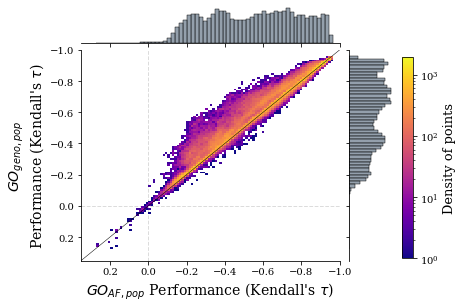

In [4]:
ax = scatter2d(
    pooled_results.loc[geno_pop.index].score,
    geno_pop.score,
    cmap=plt.cm.get_cmap('plasma'),
    marginal_kws={'color' : 'slategray'},
).ax_joint

ax.axes.set_xlim((-1, 0.35))

draw_xy(ax.axes)

ax.axes.invert_yaxis()
ax.axes.invert_xaxis()

ax.axes.axhline(0, **rt.hline_kwargs)
ax.axes.axvline(0, **rt.hline_kwargs)

ax.axes.set_title(None)

ax.axes.set_xlabel(f"{rt.factor_names['pooled']} {rt.perf_label}", fontsize=14)
ax.axes.set_ylabel(f"{rt.factor_names['ind-avg']}\n{rt.perf_label}", fontsize=14)

# save_pdf('/home/b.lind/work/tmp/scatter_lognorm.pdf')
save_pdf(f'{fig_dir}/geno-pop_af-pop_scatter2d.pdf')

<a id='exp'></a>
# explore data where geno,pop performance is better than af,pop

[top](#home)

### isolate datasets where geno,pop performance was better than af,pop performance

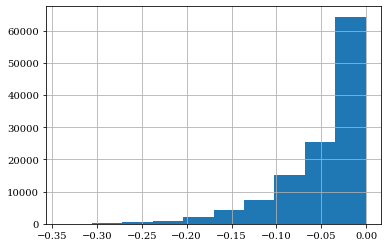

(120212, 18)

In [5]:
data = geno_pop.loc[
    geno_pop.score < pooled_results.loc[geno_pop.index].score
].copy()

data['diff'] = geno_pop.loc[data.index].score - pooled_results.loc[data.index].score
data['perc_diff'] = data['diff'] / data['score']

data['diff'].hist()
plt.show()

data.shape

In [6]:
# what perc of geno_pop had greater performance than pooeld?
nrow(data) / nrow(geno_pop)

0.7420493827160494

### what percent of original levels increased in performance between ind-averaged vs pooled data?

simulation parameters don't impact performnace much except for Landscape, and to some extent Population Size

In [7]:
for hue in rt.hue_order:
    if hue in data.columns.tolist() and hue != 'source':
        print(ColorText(rt.factor_names[hue].replace('\n', ' ')).bold())

        counts = data[hue].astype(str).value_counts()
        allcounts = geno_pop[hue].astype(str).value_counts()
        for subhue in rt.hue_order[hue]:
            factor = rt.factor_names[subhue]
            count = counts[subhue]
            allcount = allcounts[subhue]
            perc = round((count / allcount) * 100, 2)
            print(
                ColorText(factor).custom(rt.boxplot_kwargs['palette'][subhue]),
                ' ' * (3 + 25 - len(factor)),
                ColorText(f'{count} / {allcount}  -  {perc}%').bold(),
            )
        print('\n')

Landscape
Stepping Stone - Clines       31639 / 54000  -  58.59%
Stepping Stone - Mountain     50404 / 54000  -  93.34%
Estuary - Clines              38169 / 54000  -  70.68%


Polygenicity
oligogenic                    39725 / 54000  -  73.56%
moderately polygenic          40083 / 54000  -  74.23%
highly polygenic              40404 / 54000  -  74.82%


Pleiotropy
no pleiotropy                 60013 / 81000  -  74.09%
pleiotropy                    60199 / 81000  -  74.32%


Selection Strength
equal-S                       61355 / 81000  -  75.75%
unequal-S                     58857 / 81000  -  72.66%


Population Size
N-equal                       47850 / 64800  -  73.84%
N-variable                    22614 / 32400  -  69.8%
N-cline-center-to-edge        21550 / 32400  -  66.51%
N-cline-N-to-S                28198 / 32400  -  87.03%


Migration
m-constant                    70962 / 97200  -  73.01%
m-variable                    22614 / 32400  -  69.8%
m-breaks                      266

<a id='comp2'></a>
# compare differences in performance between AF,pop and geno,pop

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/geno-pop_minus_af-pop_histo_box_stacked.pdf


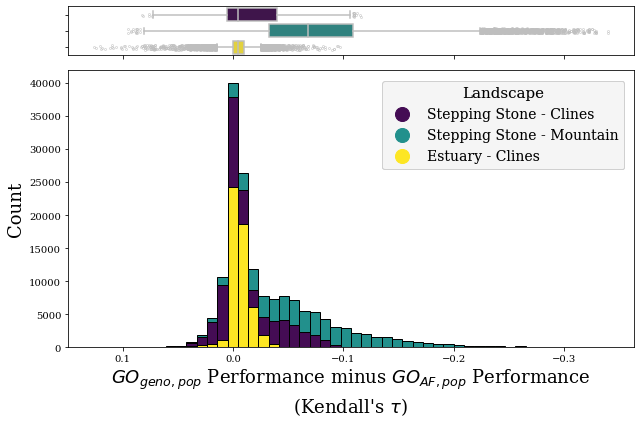

In [8]:
all_diffs = (geno_pop.score - pooled_results.loc[geno_pop.index].score).to_frame()
all_diffs['landscape'] = all_diffs.index.map(pooled_results.landscape)

# make a figure
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(9, 6),
                                      gridspec_kw={"height_ratios": (.15, .85)})

# create and edit boxplot
sns.boxplot(
    data=all_diffs,
    y='landscape',
    x='score',
    ax=ax_box,
    order=mvp.hue_order['landscape'],
    **rt.boxplot_kwargs
)

ax_box.set_yticklabels([None] * 3)
# mvp.update_ticklabels(ax_box, update='y', fontsize=12)
mvp.jitter_fliers(axes=[ax_box], jitter_axis='y', jit=0.15)
ax_box.set_ylabel(None)
ax_box.set_xlabel(None)

# create and edit stacked histogram
histdata = all_diffs.groupby('landscape')['score'].apply(pd.DataFrame)
ax_hist.hist(
    histdata,
    edgecolor='k',
    stacked=True,
    color=histdata.columns.map(mvp.boxplot_kwargs['palette']),
    bins=50
)

ax_hist.set_ylabel('Count', fontsize=18)
ax_hist.set_xlabel(f"{rt.factor_names['ind-avg']} Performance minus " +
                   f"{rt.factor_names['pooled']} Performance\n(Kendall's $\\tau$)", fontsize=18)

mvp.add_legend(fig, color_by='landscape', loc='center right', bbox_to_anchor=(0.98, 0.70), fontsize=14)

ax_hist.invert_xaxis()

plt.tight_layout()

save_pdf(f'{fig_dir}/geno-pop_minus_af-pop_histo_box_stacked.pdf')

plt.show()

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/geno-pop_minus_af-pop_histo_box.pdf


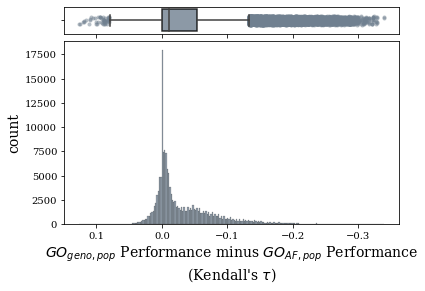

In [9]:
# same plot as above, 
    # but not colored by landscape (and different bins, this is why y-axis has different limits than above)
all_diffs = geno_pop.score - pooled_results.loc[geno_pop.index].score

fig, ax = plt.subplots()

ax_box, ax_hist = histo_box(
    all_diffs,
    histplot_kws={'color' : 'slategray'},
    markerfacecolor='slategray',
    boxplot_kws={'boxprops' : {'color' : 'slategray', 'edgecolor' : 'k', 'alpha' : 0.8}},
    ax=ax
)

ax.set_xlabel(f"{rt.factor_names['ind-avg']} Performance minus " +
              f"{rt.factor_names['pooled']} Performance\n(Kendall's $\\tau$)", fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax_box.invert_xaxis()

save_pdf(f'{fig_dir}/geno-pop_minus_af-pop_histo_box.pdf')

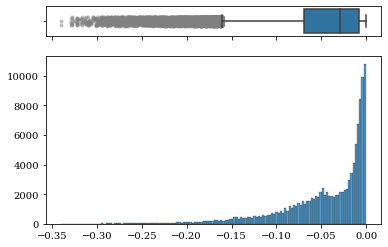

(-0.3564513957263787, 0.01655059556369022)

In [10]:
# zoom in on data where performance was better for AF,pop than geno,pop
ax_box, ax_hist = histo_box(all_diffs[all_diffs < 0])
ax_hist.get_xlim()

29583


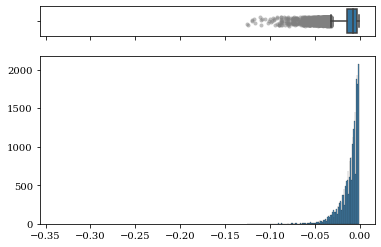

In [11]:
# isolate positive values (where af,pop scores are better, more negative, than geno,pop scores)
bad_data = geno_pop.index[
    geno_pop.score > pooled_results.loc[geno_pop.index].score
]

print(len(bad_data))

# show a boxplot to compare to immediately above (note change of subtraction order)
ax_box, ax_hist = histo_box(
    pooled_results.loc[bad_data].score - geno_pop.loc[bad_data].score,
    xlim=(-0.3564513957263787, 0.01655059556369022)
)
plt.show()

### what percent of original levels increased in performance between ind-averaged vs pooled data above baseline?

In [12]:
def print_sig(cutoff=-0.08, exclude_loci=None):
    sig_data = data[data['diff'] < cutoff].copy()
    a_results = geno_pop.copy()
    
    
    if exclude_loci is not None:
        print(f'{sig_data.shape = }')
        assert exclude_loci in sig_data.num_loci.tolist()
        sig_data = sig_data[sig_data.num_loci != exclude_loci]
        print(f'{sig_data.shape = }')
        a_results = a_results[a_results.num_loci != exclude_loci]
    
    for hue in rt.hue_order:
        if hue in sig_data.columns.tolist():
            print(ColorText(rt.factor_names[hue].replace('\n', ' ')).bold())

            counts = sig_data[hue].astype(str).value_counts()
            allcounts = a_results[hue].astype(str).value_counts()
            for subhue in rt.hue_order[hue]:
                if subhue in keys(counts):
                    factor = rt.factor_names[subhue]
                    count = counts[subhue]
                    allcount = allcounts[subhue]
                    perc = round((count / allcount) * 100, 2)
                    print(
                        ColorText(factor).custom(rt.boxplot_kwargs['palette'][subhue]),
                        ' ' * (3 + 25 - len(factor)),
                        ColorText(f'{count} / {allcount}  -  {perc}%').bold(),
                    )
            print('\n')
            
    return sig_data

In [13]:
datap05 = print_sig(cutoff=-0.05)

Landscape
Stepping Stone - Clines       9259 / 54000  -  17.15%
Stepping Stone - Mountain     33912 / 54000  -  62.8%
Estuary - Clines              94 / 54000  -  0.17%


Polygenicity
oligogenic                    14330 / 54000  -  26.54%
moderately polygenic          14506 / 54000  -  26.86%
highly polygenic              14429 / 54000  -  26.72%


Pleiotropy
no pleiotropy                 21366 / 81000  -  26.38%
pleiotropy                    21899 / 81000  -  27.04%


Selection Strength
equal-S                       20646 / 81000  -  25.49%
unequal-S                     22619 / 81000  -  27.92%


Population Size
N-equal                       18106 / 64800  -  27.94%
N-variable                    6775 / 32400  -  20.91%
N-cline-center-to-edge        4824 / 32400  -  14.89%
N-cline-N-to-S                13560 / 32400  -  41.85%


Migration
m-constant                    26104 / 97200  -  26.86%
m-variable                    6775 / 32400  -  20.91%
m-breaks                      10386 / 32

In [14]:
datap08 = print_sig(cutoff=-0.08)

Landscape
Stepping Stone - Clines       1262 / 54000  -  2.34%
Stepping Stone - Mountain     22556 / 54000  -  41.77%
Estuary - Clines              11 / 54000  -  0.02%


Polygenicity
oligogenic                    7925 / 54000  -  14.68%
moderately polygenic          8005 / 54000  -  14.82%
highly polygenic              7899 / 54000  -  14.63%


Pleiotropy
no pleiotropy                 11676 / 81000  -  14.41%
pleiotropy                    12153 / 81000  -  15.0%


Selection Strength
equal-S                       11669 / 81000  -  14.41%
unequal-S                     12160 / 81000  -  15.01%


Population Size
N-equal                       9368 / 64800  -  14.46%
N-variable                    4273 / 32400  -  13.19%
N-cline-center-to-edge        2110 / 32400  -  6.51%
N-cline-N-to-S                8078 / 32400  -  24.93%


Migration
m-constant                    15286 / 97200  -  15.73%
m-variable                    4273 / 32400  -  13.19%
m-breaks                      4270 / 32400  -  

<a id='look'></a>
# look at individual seed with most improvement

[top](#home)

### seed with most gardens improved

In [15]:
datap08[datap08['diff'] < -0.2].sort_values(by='score', ascending=True)

,garden,score,seed,num_loci,rep,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,offset_level,source,diff,perc_diff
1231422_41_500,41,-0.829655,1231422,500,225-450,0.568739,mod-polygenic,2-trait,no pleiotropy,equal-S,SS-Mtn,N-equal,m-constant,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,ind-avg,-0.220104,0.265296
1231422_50_500,50,-0.829655,1231422,500,225-450,0.568739,mod-polygenic,2-trait,no pleiotropy,equal-S,SS-Mtn,N-equal,m-constant,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,ind-avg,-0.220104,0.265296
1231648_51_5000,51,-0.827219,1231648,5000,450-675,0.549334,mod-polygenic,2-trait,no pleiotropy,equal-S,SS-Mtn,N-variable,m-variable,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,ind-avg,-0.207109,0.250368
1231648_60_5000,60,-0.827219,1231648,5000,450-675,0.549334,mod-polygenic,2-trait,no pleiotropy,equal-S,SS-Mtn,N-variable,m-variable,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,ind-avg,-0.207109,0.250368
1231648_40_10000,40,-0.816254,1231648,10000,450-675,0.549334,mod-polygenic,2-trait,no pleiotropy,equal-S,SS-Mtn,N-variable,m-variable,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,mod-polygenic_2-trait_no pleiotropy_equal-S_SS...,ind-avg,-0.201424,0.246766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231165_57_5000,57,-0.326096,1231165,5000,0-225,0.401934,highly-polygenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,highly-polygenic_2-trait_pleiotropy_unequal-S_...,highly-polygenic_2-trait_pleiotropy_unequal-S_...,ind-avg,-0.220917,0.677460
1231765_57_5000,57,-0.319598,1231765,5000,450-675,0.389291,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg,-0.233912,0.731893
1231765_54_5000,54,-0.319598,1231765,5000,450-675,0.389291,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,ind-avg,-0.233912,0.731893
1231165_57_10000,57,-0.317974,1231165,10000,0-225,0.401934,highly-polygenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,highly-polygenic_2-trait_pleiotropy_unequal-S_...,highly-polygenic_2-trait_pleiotropy_unequal-S_...,ind-avg,-0.214419,0.674330


In [16]:
# get popdata for seed in first row of `datap08`
seed = '1231422'

subset, locations, envdata = mvp06.get_pop_data(mvp.slimdir, seed)

fitness_mat = {
    'ind' : mvp03.load_ind_fitness_matrix(mvp.slimdir, seed, subset),
    'pooled' : mvp06.load_pooled_fitness_matrix(mvp.slimdir, seed)
}

samppop = dict(zip(subset['indID'], subset['subpopID']))


Reading in info for subsampled individuals ...


In [17]:
subset.head()

,seed,subpopID,indID,indSubpopIndex,subpop,phen_sal,phen_temp,sal_opt,temp_opt,fitness,subset,N,opt0,opt1,x,y,PC1,PC2,PC3,LFMM_U1_temp,LFMM_U1_sal,LFMM_U2_temp,LFMM_U2_sal,RDA1,RDA2,RDA1_corr,RDA2_corr,RDA_PC1,RDA_PC2,RDA_PC1_corr,RDA_PC2_corr,RDA_predict_tempPhen_20KSNPs,RDA_predict_salPhen_20KSNPs,RDA_predict_tempPhen_20KSNPs_structcorr,RDA_predict_salPhen_20KSNPs_structcorr,sample_name
2,1231422,1,2,2,1,-1.18980,-0.942462,-1.0,-1.0,0.961430,True,100,-1.0,-1.0,1,1,62.0487,6.97666,-48.1752,-27.592861,32.183010,-26.132169,12.555144,-2.668017,-3.133509,-3.392843,-5.234146,-3.302350,4.250048,-4.157833,3.874894,-1.553437,-1.919995,-1.023107,-1.943762,2
6,1231422,1,6,6,1,-0.71841,-0.813656,-1.0,-1.0,0.892243,True,100,-1.0,-1.0,1,1,51.7444,8.56933,-31.7369,-22.131540,27.319889,-16.388220,9.041111,-2.372976,-1.968539,-2.178764,-5.475137,-2.636226,2.674925,-2.434413,2.863129,-1.394266,-1.205116,-1.423067,-1.210298,6
20,1231422,1,20,20,1,-1.03744,-1.038360,-1.0,-1.0,0.997131,True,100,-1.0,-1.0,1,1,57.0480,4.09489,-36.2274,-26.142036,28.724626,-19.008728,12.988571,-2.286971,-2.615821,-2.860213,-5.735433,-3.122640,3.070177,-2.798741,3.321161,-1.329860,-1.565864,-1.524047,-1.603004,20
26,1231422,1,26,26,1,-1.00466,-0.968936,-1.0,-1.0,0.999014,True,100,-1.0,-1.0,1,1,53.6827,7.17844,-36.3102,-24.019209,28.144600,-18.916639,10.773704,-2.354980,-2.087039,-2.311749,-5.398702,-2.863073,3.097141,-2.859719,2.830944,-1.371741,-1.320472,-1.389126,-1.337480,26
30,1231422,1,30,30,1,-1.10544,-0.826239,-1.0,-1.0,0.959531,True,100,-1.0,-1.0,1,1,57.3229,5.61627,-44.8742,-25.469186,29.498295,-24.313635,11.692927,-2.439137,-2.604192,-2.844711,-5.318254,-3.042605,3.978576,-3.776870,3.530062,-1.418695,-1.608704,-1.282382,-1.632081,30


In [18]:
envdata.head()

,sal_opt,temp_opt
subpopID,,
1,-1.0,-1.0
2,-0.5,-1.0
3,0.0,-1.0
4,0.5,-1.0
5,1.0,-1.0


In [19]:
locations.head()

,lon,lat
subpopID,,
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0


### make figs

In [20]:
def get_avg_offsets(seed, ind_offset):
    """Average offset predicted across individuals for each population.
    
    Notes
    -----
    - modified from 06_run_time_project/03_calculate_ind-averaged_performance/00_calc_ind-averaged_performance.ipynb
    - I didn't save the ind_avg offsets in original notebook, i need them for scatter plots
    - this basically modified to skip performance calc and combines functions from 06.03.00
    """
    from pythonimports import keys
    import pandas as pd
    import numpy as np
    
    # get individual and population info
    subset = mvp01.read_ind_data(mvp.slimdir, seed)
    subset.subpopID = subset.subpopID.astype(str)
    subset.indID = subset.indID.astype(str)  # to match columns in offset df

    # map individual IDs to population IDs - key = popID value = list of indIDs
    popsamps = subset.groupby('subpopID')['indID'].apply(list).to_dict()

    # for each pop average the offset across the pop's individuals
    avg_offsets = []
    for pop, samps in popsamps.items():
        pop_offset = ind_offset[samps].copy()

        # average offset of individuals (colums) to each of the common gardens (rows)
        offset_series = pop_offset.apply(np.mean, axis=1)
        offset_series.name = pop

        avg_offsets.append(
            offset_series
        )

    # combine pop-level averages and sort columns
    avg_offsets = pd.concat(avg_offsets, axis=1)[map(str, sorted([int(pop) for pop in keys(popsamps)]))]

    return avg_offsets


# get offset 
offsets = wrap_defaultdict(dict, 3)
for source in ['ind', 'pooled']:
    for num_loci in pooled_results.num_loci.astype(str).unique():

        repdir = f'/work/lotterhos/brandon/{source}_runtimes/run_20220919_225-450/{num_loci.zfill(5)}'
        
        offset_pkl = f'{repdir}/gradient_forests/validation/offset_dfs/{seed}_offset_dfs.pkl'
        
        offsets[num_loci][source] = pklload(offset_pkl)[source]['all']
        
        if source == 'ind':
            offsets[num_loci]['ind-avg'] = get_avg_offsets(seed, offsets[num_loci][source])
            
    
offsets[num_loci][source]


Reading in info for subsampled individuals ...

Reading in info for subsampled individuals ...

Reading in info for subsampled individuals ...


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.000000,0.005344,0.015480,0.027373,0.041163,0.041163,0.027373,0.015480,0.005344,0.000000,0.006912,0.008737,0.016953,0.028232,0.041740,0.041740,0.028232,0.016953,0.008737,0.006912,0.017206,0.018017,0.023145,0.032332,0.044615,0.044615,0.032332,0.023145,0.018017,0.017206,0.032433,0.032870,0.035937,0.042440,0.052405,0.052405,0.042440,0.035937,0.032870,0.032433,0.049650,0.049937,0.052007,0.056695,0.064494,0.064494,0.056695,0.052007,0.049937,0.049650,0.065462,0.065680,0.067268,0.070955,0.077329,0.077329,0.070955,0.067268,0.065680,0.065462,0.081164,0.081340,0.082627,0.085655,0.091006,0.091006,0.085655,0.082627,0.081340,0.081164,0.094170,0.094322,0.095434,0.098068,0.102774,0.102774,0.098068,0.095434,0.094322,0.094170,0.103917,0.104054,0.105063,0.107461,0.111772,0.111772,0.107461,0.105063,0.104054,0.103917,0.117757,0.117878,0.118770,0.120896,0.124744,0.124744,0.120896,0.118770,0.117878,0.117757
2,0.005344,0.000000,0.010136,0.022029,0.035820,0.035820,0.022029,0.010136,0.000000,0.005344,0.008737,0.006912,0.012268,0.023088,0.036480,0.036480,0.023088,0.012268,0.006912,0.008737,0.018017,0.017206,0.019970,0.027952,0.039738,0.039738,0.027952,0.019970,0.017206,0.018017,0.032870,0.032433,0.033980,0.039207,0.048321,0.048321,0.039207,0.033980,0.032433,0.032870,0.049937,0.049650,0.050674,0.054317,0.061222,0.061222,0.054317,0.050674,0.049650,0.049937,0.065680,0.065462,0.066243,0.069070,0.074622,0.074622,0.069070,0.066243,0.065462,0.065680,0.081340,0.081164,0.081794,0.084100,0.088717,0.088717,0.084100,0.081794,0.081164,0.081340,0.094322,0.094170,0.094714,0.096713,0.100753,0.100753,0.096713,0.094714,0.094170,0.094322,0.104054,0.103917,0.104410,0.106226,0.109917,0.109917,0.106226,0.104410,0.103917,0.104054,0.117878,0.117757,0.118192,0.119799,0.123084,0.123084,0.119799,0.118192,0.117757,0.117878
3,0.015480,0.010136,0.000000,0.011893,0.025684,0.025684,0.011893,0.000000,0.010136,0.015480,0.016953,0.012268,0.006912,0.013755,0.026597,0.026597,0.013755,0.006912,0.012268,0.016953,0.023145,0.019970,0.017206,0.020916,0.030914,0.030914,0.020916,0.017206,0.019970,0.023145,0.035937,0.033980,0.032433,0.034544,0.041371,0.041371,0.034544,0.032433,0.033980,0.035937,0.052007,0.050674,0.049650,0.051054,0.055899,0.055899,0.051054,0.049650,0.050674,0.052007,0.067268,0.066243,0.065462,0.066534,0.070321,0.070321,0.066534,0.065462,0.066243,0.067268,0.082627,0.081794,0.081164,0.082031,0.085131,0.085131,0.082031,0.081164,0.081794,0.082627,0.095434,0.094714,0.094170,0.094918,0.097610,0.097610,0.094918,0.094170,0.094714,0.095434,0.105063,0.104410,0.103917,0.104595,0.107043,0.107043,0.104595,0.103917,0.104410,0.105063,0.118770,0.118192,0.117757,0.118356,0.120525,0.120525,0.118356,0.117757,0.118192,0.118770
4,0.027373,0.022029,0.011893,0.000000,0.013791,0.013791,0.000000,0.011893,0.022029,0.027373,0.028232,0.023088,0.013755,0.006912,0.015426,0.015426,0.006912,0.013755,0.023088,0.028232,0.032332,0.027952,0.020916,0.017206,0.022051,0.022051,0.017206,0.020916,0.027952,0.032332,0.042440,0.039207,0.034544,0.032433,0.035243,0.035243,0.032433,0.034544,0.039207,0.042440,0.056695,0.054317,0.051054,0.049650,0.051529,0.051529,0.049650,0.051054,0.054317,0.056695,0.070955,0.069070,0.066534,0.065462,0.066899,0.066899,0.065462,0.066534,0.069070,0.070955,0.085655,0.084100,0.082031,0.081164,0.082327,0.082327,0.081164,0.082031,0.084100,0.085655,0.098068,0.096713,0.094918,0.094170,0.095175,0.095175,0.094170,0.094918,0.096713,0.098068,0.107461,0.106226,0.104595,0.103917,0.104828,0.104828,0.103917,0.104595,0.106226,0.107461,0.120896,0.119799,0.118356,0.117757,0.118561,0.118561,0.117757,0.118356,0.119799,0.120896
5,0.041163,0.035820,0.025684,0.013791,0.000000,0.000000,0.013791,0.025684,0.035820,0.041163,0.04174

In [21]:
for (num_loci, source), offset in unwrap_dictionary(offsets):
    print(num_loci, source)

500 ind
500 ind-avg
500 pooled
5000 ind
5000 ind-avg
5000 pooled
10000 ind
10000 ind-avg
10000 pooled


In [22]:
elevation = sorted(uni(envdata['sal_opt']))
sizes = [0, 1, 2, 3, 4]

temp = envdata.temp_opt.sort_values().unique().tolist()

In [23]:
elevation

[-1.0, -0.5, 0.0, 0.5, 1.0]

In [24]:
pd.Series(temp).round(2).tolist()

[-1.0, -0.78, -0.56, -0.33, -0.11, 0.11, 0.33, 0.56, 0.78, 1.0]

<a id='figs'></a>
### make figures

[top](#home)

### create color maps for figures

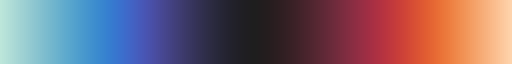

In [25]:
_ = sns.color_palette("icefire", as_cmap=True, n_colors=100)  # this displays better
icefire = sns.color_palette("icefire", n_colors=100)  # i'll actually use this
_

In [26]:
new_icefire = []
for row_start in range(1, 100, 10):
    start = row_start - 1
    stop = row_start + 9
    row_colors = pd.Series(icefire[start : stop])
    odd_colors = row_colors.loc[np.linspace(start=1, stop=9, num=5)].to_list()
    
    if row_start < 50:
        for i in range(0, 5):
            new_icefire.append(odd_colors[i])

        for i in range(0, 5):
            new_icefire.append(odd_colors[::-1][i])
    else:
        for i in range(0, 5):
            new_icefire.append(odd_colors[::-1][i])

        for i in range(0, 5):
            new_icefire.append(odd_colors[i])
    
len(new_icefire)

100

In [27]:
coolwarm = sns.color_palette("coolwarm", n_colors=10)  # for pnas map colorbar

pop_coolwarm = []  # plotting populations as in pnas
for pop, temp_opt in envdata['temp_opt'].items():
    pop_coolwarm.append(
        coolwarm[temp.index(temp_opt)]
    )
    
coolwarm

[(0.3383765114431373, 0.45281860883137254, 0.8793170768784313),
 (0.4570464785254902, 0.5940055499294118, 0.963029229690196),
 (0.5814861481882353, 0.7134505955294117, 0.9983143529411764),
 (0.7087196897176471, 0.8057213889294117, 0.9811168090470588),
 (0.8180564934117647, 0.8555896775450981, 0.9146376165490196),
 (0.9094595977529412, 0.8393864797647058, 0.8003313524235294),
 (0.9616447383764706, 0.7580291825411765, 0.6617823791647058),
 (0.963806056435294, 0.6341884145294118, 0.5137208491529413),
 (0.9182816725843137, 0.48417347218039214, 0.37779392507058823),
 (0.8301865219490197, 0.30473276355294115, 0.25489142806666665)]

In [28]:
coolwarm_100 = sns.color_palette("coolwarm", n_colors=100)

new_coolwarm = []
for row_start in range(1, 100, 10):
    start = row_start - 1
    stop = row_start + 9
    row_colors = pd.Series(coolwarm_100[start : stop])
    odd_colors = row_colors.loc[np.linspace(start=1, stop=9, num=5)].to_list()  # use every other color, for contrast
    
    if row_start >= 50:
        for i in range(0, 5):
            new_coolwarm.append(odd_colors[i])

        for i in range(0, 5):
            new_coolwarm.append(odd_colors[::-1][i])
    else:
        for i in range(0, 5):
            new_coolwarm.append(odd_colors[::-1][i])

        for i in range(0, 5):
            new_coolwarm.append(odd_colors[i])
    
len(new_coolwarm)

100

In [29]:
# bundle color maps
cmaps = {
    'icefire' : icefire,
    'new_icefire' : new_icefire,
    'coolwarm' : pop_coolwarm,
    'coolwarm_100' : coolwarm_100,
    'new_coolwarm' : new_coolwarm
}

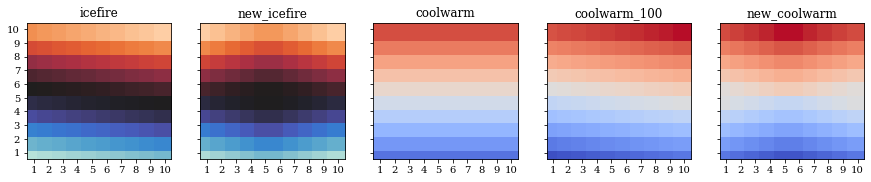

In [30]:
fig, axes = plt.subplots(figsize=(15,2.5), ncols=len(cmaps), sharex=True, sharey=True); i=0
for cmap_key, cmap in cmaps.items():
    ax = axes[i]
    for pop, (lon, lat) in locations.iterrows():
        ax.scatter(lon, lat, color=cmap[pop-1], s=500, marker='s')

    ax.set_xticks(range(1, 11, 1))
    ax.set_yticks(range(1, 11, 1))
    ax.set_title(cmap_key)

    i+=1
    
plt.show()

### make figures

10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 208.58it/s]


Saved to:  /home/b.lind/work/tmp/ind_vs_pooled_vs_ind-avg.pdf


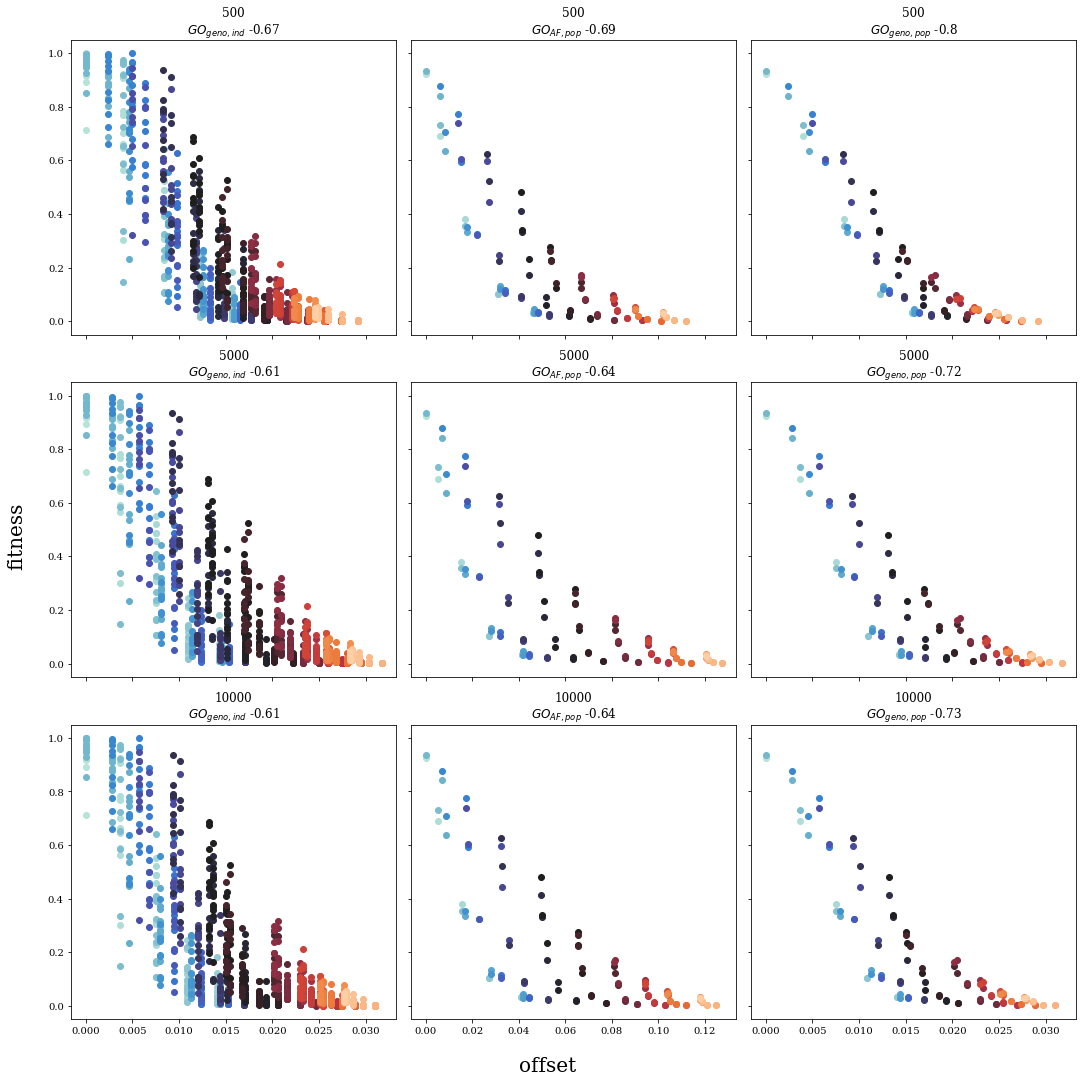

In [31]:
fig, axes = plt.subplots(
    ncols=3,
    nrows=len(rt.hue_order['num_loci']),
    figsize=(15, 15),
    sharey=True,
    sharex='col'
)

# for j, num_loci in enumerate(rt.hue_order['num_loci'] + ['20000']):
for j, num_loci in enumerate(rt.hue_order['num_loci']):
    
    row_axes = axes[j]
    
    for i, source in enumerate(['ind', 'pooled', 'ind-avg']):
        offset = offsets[num_loci][source]
        fitness = fitness_mat[source if source != 'ind-avg' else 'pooled']
        
        if source == 'ind':
            colors = [icefire[samppop[int(ind)] - 1] for ind in offset.columns]
        else:
            colors = icefire.copy()
        
        for j, ind_or_pop in enumerate(pbar(offset.columns, desc=f'{num_loci} {source}')):
            row_axes[i].scatter(
                offset.loc[1, ind_or_pop],
                fitness.loc[1, ind_or_pop],
                color=colors[j]
            )
        
        _mean = offset.corrwith(fitness, axis='columns', method='kendall').mean()
        
        row_axes[i].set_title(
            f'{num_loci}\n%s %s' % (
                rt.factor_names[source],
                round(_mean, 2)
            )
        )
        
        
fig.supylabel('fitness', fontsize=20, x=0)
fig.supxlabel('offset', fontsize=20, y=0)

plt.tight_layout()

save_pdf('/home/b.lind/work/tmp/ind_vs_pooled_vs_ind-avg.pdf')

plt.show()

In [32]:
def add_env2_legend(fig_object, fontsize=11, loc='center left', bbox_to_anchor=None, ncol=1, title=None,
                    size_mult=2):
    """Add pretty legend to figure, `fig_object`.
    
    Parameters
    ----------
    fig_object : [matplotlib.figure.Figure or matplotlib.axes._subplots.AxesSubplot]
        which object of the figure to add the legend
    fontsize : int
        the fontsize of the legend title and elements
    loc : str
        location of legend with respect to bbox_to_anchor location
    bbox_to_anchor : tuple
        Box that is used to position the legend in conjunction with *loc*.
    ncol : int
        the number of columns in the legend
    title : str
        legend title
    size_mult : float
        size multiplier
    """
    legend_kws = dict(title=f'$\it{title}$', fancybox=True, shadow=False,
                      facecolor='whitesmoke', loc=loc, bbox_to_anchor=bbox_to_anchor,
                      prop=dict(family='serif', size=fontsize))
    
    # get the things that go into the legend
    handles = []
    for size in sizes:
        handles.append(
            Line2D([0], [0], marker='o', color='none', markerfacecolor='k',
                   markeredgecolor='k',
                   label=elevation[size],
                   markersize=size_mult*size if size != 0 else 1)
        )

    # create a legend
    leg1 = fig_object.legend(handles=handles, ncol=ncol, **legend_kws)
    fig_object.add_artist(leg1)
    plt.setp(leg1.get_title(), family='serif', fontsize=fontsize+1)
    leg1.get_title().set_multialignment('center')

    return leg1

In [33]:
# functions for plotting the conceptual landscape map
def plot_pnas(fig, ax):
    """Plot a PNAS-style map on the fourth fig."""
    for pop, (lon, lat) in locations.iterrows():
        e, t = envdata.loc[pop, ['sal_opt', 'temp_opt']]
        # add black dot
        ax.scatter(
            lon,
            lat,
            s=50 * sizes[elevation.index(e)],
            color='k'
        )
        # add colored dot on top
        ax.scatter(
            lon,
            lat,
            s=30,
            color=coolwarm[temp.index(t)]
        )
        # add garden location
        if pop == 1:
            ax.scatter(
                lon,
                lat,
                s=400,
                marker='*',
                color='white',
                edgecolor='k',
                zorder=0
            )

    # add temp color bar
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm'), 
                      aspect=3,
                      ax=ax,
                      fraction=0.08,
                      anchor=(0, 1)
                     )
    cb.set_label(label='Temperature', size=12)

    add_env2_legend(fig, title='Env2', loc='center left', bbox_to_anchor=(0.945, 0.35), size_mult=1.5)
    
    return fig


def plot_icefire(fig, ax, pop_color_map=icefire):
    """Plot a N-S gradient map on the fourth fig."""
    from matplotlib.patches import Rectangle
    
    for pop, (lon, lat) in locations.iterrows():
       
        xy = (lon - 0.5, lat -0.5)
        ax.add_patch(
            Rectangle(xy, width=1, height=1, facecolor=pop_color_map[pop-1],)# linewidth=3)
        )
        
        # add garden location
        if pop == 1:
            ax.scatter(
                lon,
                lat,
                s=200,
                marker='*',
                color='k'
            )
            
    ax.set_xlim((0.5, 10.5))
    ax.set_ylim((0.5, 10.5))
    
    return fig

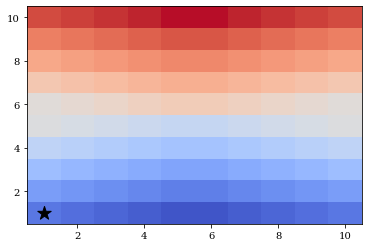

In [34]:
# test
fig, ax = plt.subplots()

plot_icefire(fig, ax, pop_color_map=cmaps['new_coolwarm'])
plt.show()

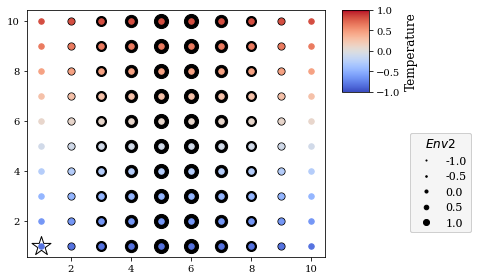

In [35]:
# test
fig, ax = plt.subplots()

plot_pnas(fig, ax)
plt.tight_layout()
plt.show()

In [36]:
# functions for comparing among GO_i,j
@timer
def plot_comparisons(maptype='pnas', cmap_key='icefire', garden_ID=1, use_rank=False, num_loci=str(10_000),
                     scatter_type=None):
    """Plot comparisons and add one of two `maptype`s in fourth subgfig."""
    pop_color_map = cmaps[cmap_key]

    fig, axes = plt.subplots(
        ncols=4,
        figsize=(18, 3.5),
    )

    # for the first three subfigs - af,pop then geno,pop, then geno,ind
    for ax, source in zip(axes, ['ind', 'pooled', 'ind-avg']):

        # get data for scatter plotting
        offset = offsets[num_loci][source]
        fitness = fitness_mat[source if source != 'ind-avg' else 'pooled']

        # scatter the plot
        for j, ind_or_pop in enumerate(pbar(offset.columns, desc=f'{num_loci} {source}')):
            # get colors for scatter points
            if source == 'ind':
                color = pop_color_map[samppop[int(ind_or_pop)] - 1]
                temp, env2 = subset.loc[ind_or_pop, ['temp_opt', 'sal_opt']]
            else:
                color = pop_color_map[j]
                temp, env2 = envdata.loc[int(ind_or_pop), ['temp_opt', 'sal_opt']]
            
            if use_rank is False:
                x = offset.loc[garden_ID, ind_or_pop]
                y = fitness.loc[garden_ID, ind_or_pop]
            else:
                x = offsets[num_loci][source].loc[garden_ID].rank(ascending=True).loc[ind_or_pop]
                y = fitness.loc[1].rank(ascending=False).loc[ind_or_pop]

            if scatter_type == 'pnas':
                # plot black dot background point first
                ax.scatter(
                    x,
                    y,
                    color='k',
                    s=20 * sizes[elevation.index(env2)]
                )     
            # plot colored point
            ax.scatter(
                x,
                y,
                color=color,
                s=20
            )
            

        # the average common garden performance (not just of `garden_ID`)
        _mean = offset.corrwith(fitness, axis='columns', method='kendall').mean()
        print(f"{rt.factor_names[source]} mean CG performance across landscape = {_mean}")
        # the relationship between the scatter points
        _mean2 = offset.loc[garden_ID].corr(fitness.loc[1], method='kendall')
        ax.text(
            x=0.95,
            y=0.85,
            s=f"Kendall's $\\tau$ = {round(_mean2, 3)}",
            fontsize=14,
            transform=ax.transAxes,
            ha='right'
        )
        
        if use_rank is False:
            ax.tick_params(axis='x', which='major', labelcolor='white')
        ax.set_title(f"{rt.factor_names[source]}", fontsize=20)
        
        if use_rank is True:
            if source != 'ind':
                ax.axvline(10, **rt.hline_kwargs)
                ax.axhline(10, **rt.hline_kwargs)
            else:
                ax.axvline(100, **rt.hline_kwargs)
                ax.axhline(100, **rt.hline_kwargs)
        else:
            ax.axhline(fitness.loc[1].quantile(0.9), **rt.hline_kwargs)
            ax.axvline(offset.loc[1].quantile(0.1), **rt.hline_kwargs)
                    
        if source == 'ind':
            ax.set_ylabel("fitness%s" % (' rank (highest = 1)' if use_rank is True else ''),
                          fontsize=17)
        if source == 'pooled':
            ax.set_xlabel("offset%s" % (' rank (lowest = 1)' if use_rank is True else ''),
                          fontsize=17)
#         if source != 'pooled':
#             ax.tick_params(axis='y', which='major', labelleft=False)

        if use_rank is True:
            ax.set_ylim((len(offset.columns) * 1.1), 0 - len(offset.columns) * 0.1)  # invert y-axis so highest offset is higher
        else:
            ax.set_ylim((-0.05, 1.05))


    axes[-1].set_ylabel('latitude', fontsize=16, labelpad=0)
    axes[-1].set_xlabel('longitude', fontsize=16)
    axes[-1].set_title('Environmental Map', fontsize=20)
    axes[-1].set_xticks(range(1, 11, 1))
    axes[-1].set_yticks(range(1, 11, 1))
    
    if maptype == 'pnas':
        fig = plot_pnas(fig, axes[-1])
    elif maptype == 'icefire':
        fig = plot_icefire(fig, axes[-1], pop_color_map=pop_color_map)
    else:
        raise NotImplementedError('bad maptype')
        
    plt.tight_layout(pad=0)
        
    save_pdf(f'{fig_dir}/top_plot_{maptype}_{scatter_type}_{use_rank}_{cmap_key}_{num_loci}.pdf')
    plt.show()
    
    pass

10000 ind: 100%|███████████████| 1000/1000 [00:07<00:00, 141.33it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 279.84it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 285.61it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_pnas_pnas_True_coolwarm_10000.pdf


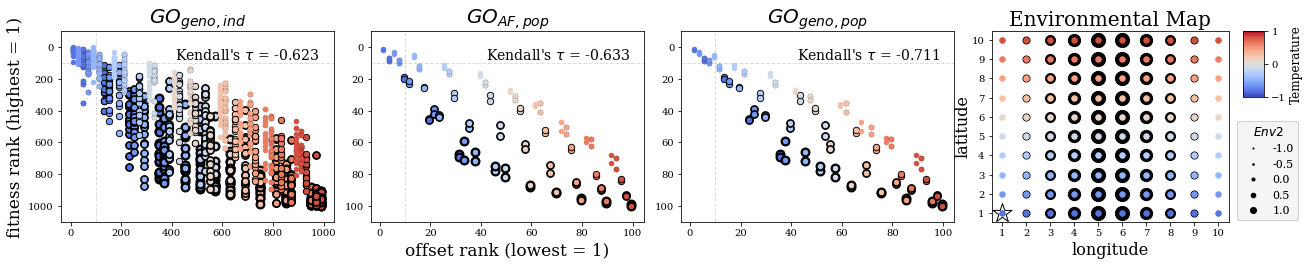

Function `plot_comparisons` completed after : 0-00:00:35


In [37]:
plot_comparisons(maptype='pnas', scatter_type='pnas', use_rank=True, cmap_key='coolwarm')

10000 ind: 100%|███████████████| 1000/1000 [00:06<00:00, 156.34it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 287.65it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 288.47it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_pnas_pnas_False_coolwarm_10000.pdf


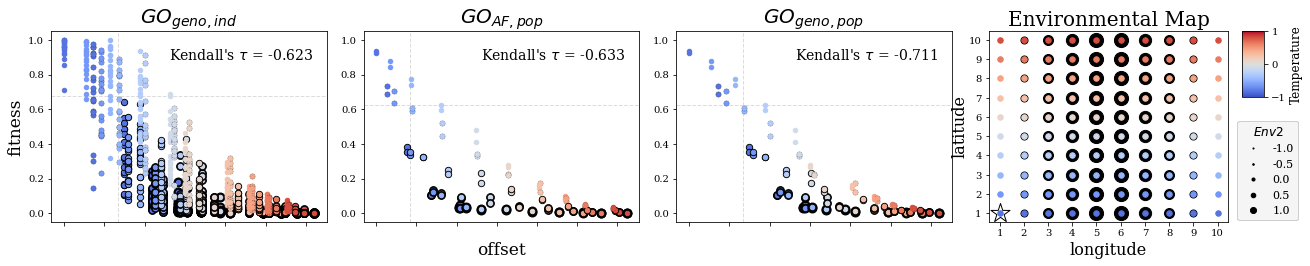

Function `plot_comparisons` completed after : 0-00:00:36


In [38]:
plot_comparisons(maptype='pnas', scatter_type='pnas', use_rank=False, cmap_key='coolwarm')

10000 ind: 100%|███████████████| 1000/1000 [00:02<00:00, 337.35it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 317.55it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 447.83it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_icefire_None_True_new_coolwarm_10000.pdf


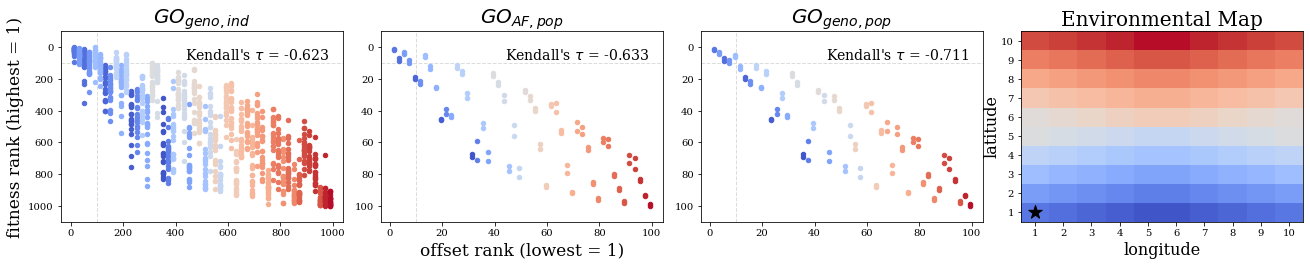

Function `plot_comparisons` completed after : 0-00:00:18


In [39]:
plot_comparisons(maptype='icefire', use_rank=True, cmap_key='new_coolwarm')

10000 ind: 100%|███████████████| 1000/1000 [00:02<00:00, 356.85it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 585.39it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 572.39it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_icefire_None_False_new_coolwarm_10000.pdf


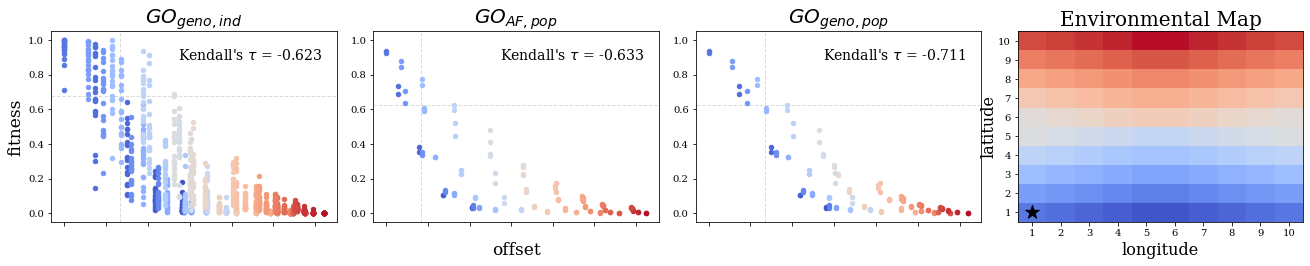

Function `plot_comparisons` completed after : 0-00:00:17


In [40]:
plot_comparisons(maptype='icefire', use_rank=False, cmap_key='new_coolwarm')

10000 ind: 100%|███████████████| 1000/1000 [00:02<00:00, 340.39it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 478.10it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 476.22it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_icefire_None_True_new_icefire_10000.pdf


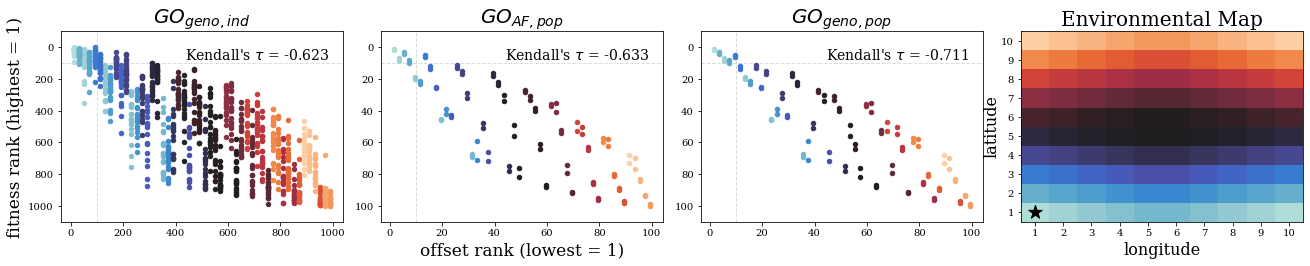

Function `plot_comparisons` completed after : 0-00:00:17


In [41]:
plot_comparisons(maptype='icefire', use_rank=True, cmap_key='new_icefire')

10000 ind: 100%|███████████████| 1000/1000 [00:03<00:00, 321.12it/s]


$\it{GO}_{geno, ind}$ mean CG performance across landscape = -0.614430373678292


10000 pooled: 100%|███████████████| 100/100 [00:00<00:00, 563.70it/s]


$\it{GO}_{AF, pop}$ mean CG performance across landscape = -0.6401950501066013


10000 ind-avg: 100%|███████████████| 100/100 [00:00<00:00, 569.36it/s]


$\it{GO}_{geno, pop}$ mean CG performance across landscape = -0.7269697721463474
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/03_all_compare_workflows/top_plot_icefire_None_False_new_icefire_10000.pdf


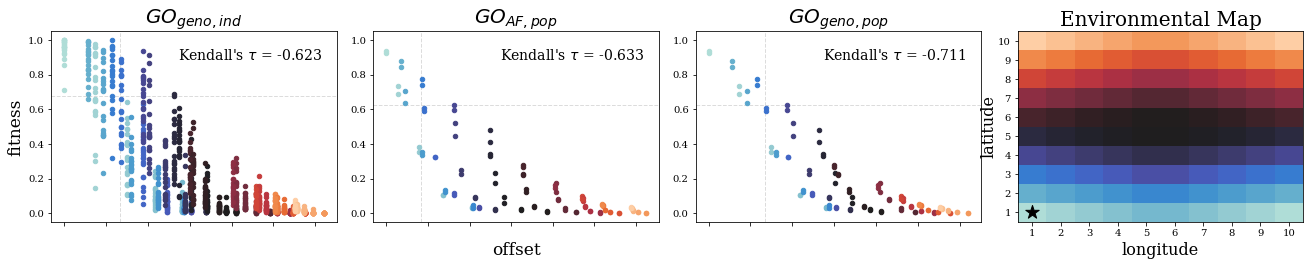

Function `plot_comparisons` completed after : 0-00:00:17


In [42]:
plot_comparisons(maptype='icefire', use_rank=False, cmap_key='new_icefire')

In [43]:
seed

'1231422'

In [44]:
params = mvp.read_params_file()

params.loc[seed, 'level']

100%|███████████████| 2250/2250 [00:02<00:00, 835.28it/s]


'mod-polygenic_2-trait-no-pleiotropy-equal-S__SS-Mtn_N-equal_m-constant'

In [45]:
formatclock(dt.now() - t0)

'0-00:04:04'